# EQS GB Cross-Validation for Simple sources

Using cross-validation to determine the best damping and depth for the model.

In [1]:
import numpy as np
import verde as vd
import matplotlib.pyplot as plt
import eqs_magnetics as eqs
from itertools import product

Set the data coordinates and field direction.

In [2]:
region = [-10e3, 10e3, -10e3, 10e3]
coordinates = vd.scatter_points(region, size=15000, random_state=0, extra_coords=500)
field_direction = eqs.angles_to_vector(inclination=84, declination=122, amplitude=1)
print("N data:", coordinates[0].size)

N data: 15000


Create the dipole source model.

In [3]:
source_inc, source_dec = 45, 45
dipole_moments = []
source_coordinates = []

# Dike NE-SW
dike_moment_magnitude = 10e7
source_coordinates.append(vd.profile_coordinates((-20e3, -5e3), (20e3, 12e3), size=1000, extra_coords=0)[0])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(1000, dike_moment_magnitude)))

# Dike NW-SE
source_coordinates.append(vd.profile_coordinates((20e3, -10e3), (-20e3, 25e3), size=1000, extra_coords=0)[0])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(1000, dike_moment_magnitude)))

# Dike small
source_coordinates.append(vd.profile_coordinates((20e3, -4e3), (4e3, 3e3), size=1000, extra_coords=0)[0])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(1000, dike_moment_magnitude)))

# # Dike very small
source_coordinates.append(vd.profile_coordinates((3e3, 3.5e3), (-0.5e3, 5.5e3), size=100, extra_coords=0)[0])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(100, dike_moment_magnitude)))

# point source top left
source_coordinates.append([[-7500], [7000], [-350]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, 1e10))

# point source centre
source_coordinates.append([[0], [-100], [-1e3]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, 5e10))

# point source bottom right
source_coordinates.append([[7500], [-7500], [-500]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, 2e10))

# point source bottom left
source_coordinates.append([[-8000], [-6000], [-800]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, 5e10))

# regional
# source_coordinates.append([c.ravel() for c in vd.grid_coordinates([-10e3, 10e3, -10e3, 10e3], shape=(10, 10), extra_coords=-30e3)])
# dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(100, 1e12)))

source_coordinates.append([[0, 5e3], [-10e3, -5e3], [-10e3, -9e3]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(2, 5e12)))

source_coordinates = np.concatenate(source_coordinates, axis=1)
dipole_moments = np.concatenate(dipole_moments, axis=1)
dipole_moments.shape, source_coordinates.shape

((3, 3106), (3, 3106))

In [4]:
magnetic_field = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)

In [5]:
total_field_anomaly = eqs.total_field_anomaly(magnetic_field, field_direction)
bnorm = eqs.magnetic_field_norm(magnetic_field)

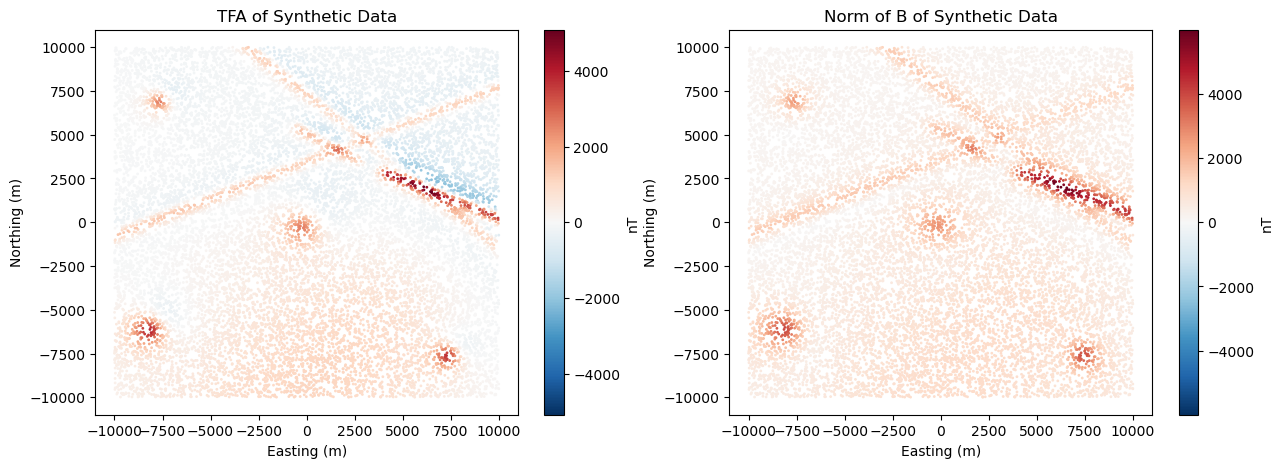

In [6]:
plt.figure(figsize=(15,5))
scale = vd.maxabs(total_field_anomaly)
#scale = 1000
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=total_field_anomaly, cmap="RdBu_r",s=1, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

scale_bnorm = vd.maxabs(bnorm)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm, cmap="RdBu_r",s=1, vmin=-scale_bnorm, vmax=scale_bnorm)
plt.title("Norm of B of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit deep sources

Block reduce the data has several advantages:

1. Less data to fit so much faster.
2. The block median reduces the wavelengths in the data, which captures the regional field and leaves the residuals alone.

In [7]:
reducer = vd.BlockReduce(reduction=np.median, spacing=2e3, drop_coords=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=total_field_anomaly)

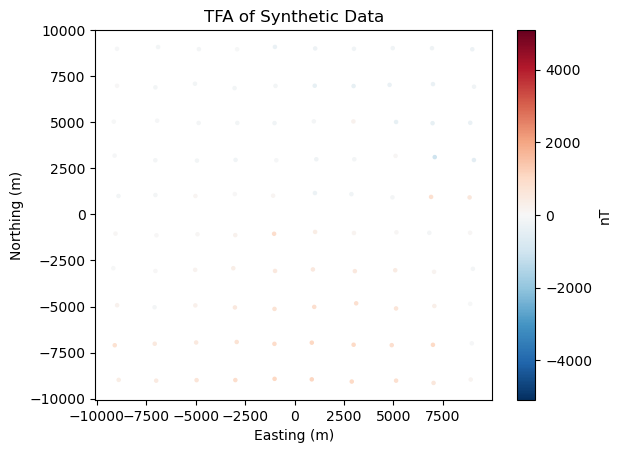

In [8]:
plt.figure()
plt.scatter(*coords_blocked[:2], c=tfa_blocked, cmap="RdBu_r", s=5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

In [9]:
eqs_deep = eqs.EquivalentSourcesMagnetic(damping=1e-5)
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -7577.809515269439


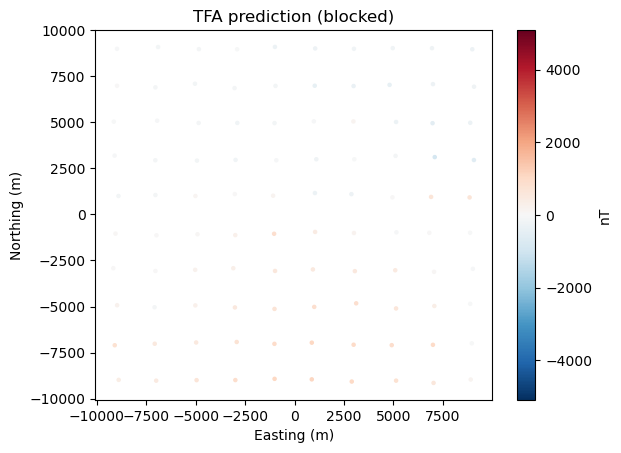

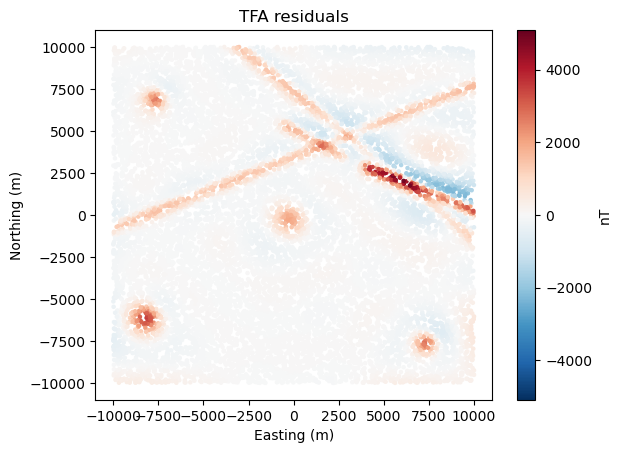

In [13]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = total_field_anomaly - tfa_deep

plt.figure()
plt.scatter(*coords_blocked[:2], c=tfa_deep_blocked, cmap="RdBu_r", s=5, vmin=-scale, vmax=scale)
plt.title("TFA prediction (blocked)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.figure()
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="RdBu_r", s=5, vmin=-scale, vmax=scale)
plt.title("TFA residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

## Fit the shallow residuals with gradient-boosted sources

In [14]:
eqs_shallow = eqs.EquivalentSourcesMagneticGB(damping=1e-5, random_state=0)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

/home/leo/bin/conda/envs/eqs-gb-norm-of-b/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/leo/bin/conda/envs/eqs-gb-norm-of-b/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/leo/bin/conda/envs/eqs-gb-norm-of-b/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/leo/bin/conda/envs/eqs-gb-norm-of-b/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


dipole height: 152.61366213487582
window size: 11544.29486148111


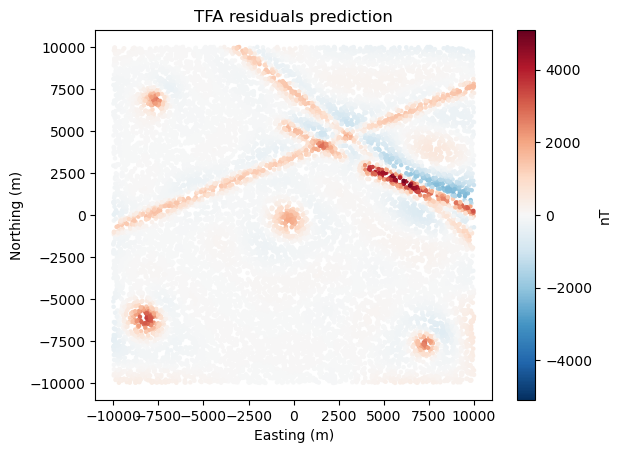

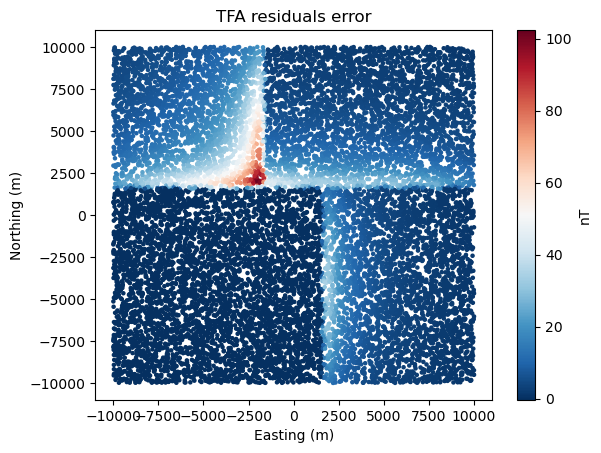

In [17]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure()
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="RdBu_r", s=5, vmin=-scale, vmax=scale)
plt.title("TFA residuals prediction")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.figure()
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, cmap="RdBu_r", s=5)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

## EQS CV Deep

In [ ]:
reducer = vd.BlockReduce(reduction=np.median, spacing=500, drop_coords=False, center_coordinates=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=total_field_anomaly)

In [ ]:
#eqs_coords_deep = vd.grid_coordinates(region, spacing=2e3, extra_coords=-1.5e3)

reducer_eqs_deep = vd.BlockReduce(reduction=np.median, spacing=2e3,  center_coordinates=False)
points_eqs_deep, _ = reducer_eqs_deep.filter(coords_blocked, coords_blocked[0])
eqs_coords_deep = list(points_eqs_deep)
eqs_coords_deep.append(np.full_like(points_eqs_deep[0], -10e3))

In [ ]:
plt.plot(*coords_blocked[:2], ".b")
plt.plot(*eqs_coords_deep[:2], ".k")
plt.show()

In [ ]:
np.linspace(-20e3, -15e3, 6)
# np.logspace(-15, -10, 6)

In [ ]:
depth_deep = np.linspace(-6e3, -4e3, 3)
mu_deep = np.logspace(-21, -18, 4)
parameters_deep = list(product(depth_deep, mu_deep))

In [ ]:
# Create cross-validators in blocks with shuffling enabled.
kfold = vd.BlockKFold(
    spacing=500,
    shuffle=True,
    random_state=0,
    balance=True,
)
# Coordinates compatible with scikit-learn
feature_matrix = np.transpose(coords_blocked[:2])

eqs_inc_deep = 90
eqs_dec_deep = 45
eqs_dipole_unit_deep = eqs.unit_vector(eqs_inc_deep, eqs_dec_deep)

damping, source_depth, rmses = [[],[],[]]

for i in parameters_deep:
    reducer_eqs_deep = vd.BlockReduce(reduction=np.median, spacing=2e3,  center_coordinates=False)
    points_eqs_deep, _ = reducer_eqs_deep.filter(coords_blocked, coords_blocked[0])
    eqs_coords_deep = list(points_eqs_deep)
    eqs_coords_deep.append(np.full_like(points_eqs_deep[0], i[0]))
    #eqs_coords_deep = vd.grid_coordinates(region, spacing=2e3, extra_coords=i[0])
    rmses_this_cv = []
    cv_fold = kfold.split(feature_matrix)
    for train, test in cv_fold:
        A = eqs.sensitivity_matrix(
            data_coords=[c[train] for c in coords_blocked], 
            source_coords=eqs_coords_deep, 
            unit_dipole_moment=eqs_dipole_unit_deep,
            main_field_direction=field_direction,
        )
        eqs_dipole_moment_amp_deep = eqs.damped_least_squares(
            data=tfa_blocked[train], sensitivity=A, damping=i[1],
        )
        eqs_dipole_moment_deep = [
            eqs_dipole_moment_amp_deep[j] * eqs_dipole_unit_deep
            for j in range(eqs_dipole_moment_amp_deep.size)
        ]
        predicted_tfa_deep = eqs.total_field_anomaly(
            eqs.dipole_magnetic_field_fast(
                data_coordinates=[c[test] for c in coords_blocked],
                dipole_coordinates=eqs_coords_deep,
                dipole_moment=eqs_dipole_moment_deep,
            ),
            field_direction,
        )
        residual = tfa_blocked[test] - predicted_tfa_deep
        rmse = np.sqrt(np.square(residual).mean())
        rmses_this_cv.append(rmse)
    rmses.append(np.mean(rmses_this_cv))
    damping.append(i[1])
    source_depth.append(i[0])

In [ ]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=rmses,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(rmses,20),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

* depth = -5e3
* damping = 1e-21

## EQS Deep

In [ ]:
reducer = vd.BlockReduce(reduction=np.median, spacing=500, drop_coords=False, center_coordinates=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=total_field_anomaly)

In [ ]:
#eqs_coords_deep = vd.grid_coordinates(region, spacing=2e3, extra_coords=-1.5e3)

reducer_eqs_deep = vd.BlockReduce(reduction=np.median, spacing=2e3,  center_coordinates=False)
points_eqs_deep, _ = reducer_eqs_deep.filter(coords_blocked, coords_blocked[0])
eqs_coords_deep = list(points_eqs_deep)
eqs_coords_deep.append(np.full_like(points_eqs_deep[0], -5e3))

In [ ]:
deep_eqs_inc = 84
deep_eqs_dec = 122
deep_eqs_dipole_unit = eqs.unit_vector(deep_eqs_inc, deep_eqs_dec)
deep_damping = 1e-21

In [ ]:
dipole_moment_deep = eqs.deep_dipole_moment(
    data_coords=coords_blocked,
    data=tfa_blocked,
    eqs_inclination=deep_eqs_inc,
    eqs_declination=deep_eqs_dec,
    eqs_dipole_unit=deep_eqs_dipole_unit,
    damping=deep_damping,
    deep_eqs_coords=eqs_coords_deep,
    main_field_direction=field_direction,
)

In [ ]:
predicted_magnetic_field_deep = eqs.dipole_magnetic_field_fast(
    coordinates,
    eqs_coords_deep,
    dipole_moment_deep,
)

predicted_tfa_deep = eqs.total_field_anomaly(
    predicted_magnetic_field_deep,
    field_direction,
)

predicted_bnorm_deep = eqs.magnetic_field_norm(
    predicted_magnetic_field_deep,
)

residuals_deep = total_field_anomaly - predicted_tfa_deep

In [ ]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.title("Observed TFA")
scale = vd.maxabs(total_field_anomaly)
plt.scatter(
    *coordinates[:2], c=total_field_anomaly, cmap="seismic", vmin=-scale, vmax=scale,
)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Predicted TFA Deep")
scale = vd.maxabs(predicted_tfa_deep)
plt.scatter(
    *coordinates[:2], c=predicted_tfa_deep, cmap="seismic", vmin=-scale, vmax=scale,
)
plt.colorbar()

plt.subplot(1,3,3)
scale = vd.maxabs(residuals_deep)
plt.title("Residuals Deep")
scale = vd.maxabs(residuals_deep)
plt.scatter(
    *coordinates[:2], c=residuals_deep, cmap="seismic", vmin=-scale, vmax=scale,
)
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.title("True B Norm")
scale = vd.maxabs(bnorm)
plt.scatter(
    *coordinates[:2], c=bnorm, cmap="seismic", vmin=-scale, vmax=scale,
)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Predicted B Norm deep")
scale = vd.maxabs(predicted_bnorm_deep)
plt.scatter(
    *coordinates[:2], c=predicted_bnorm_deep, cmap="seismic", vmin=-scale, vmax=scale,
)
plt.colorbar()
plt.subplot(1,3,3)
diff_bnorm_deep = bnorm - predicted_bnorm_deep
scale = vd.maxabs(diff_bnorm_deep)
plt.title("B Norm Diff")
plt.scatter(
    *coordinates[:2], c=diff_bnorm_deep, cmap="seismic", vmin=-scale, vmax=scale,
)
plt.colorbar()
plt.show()

In [ ]:
plt.scatter(*eqs_coords_deep[:2], c=np.linalg.norm(dipole_moment_deep, axis=1))
plt.colorbar()
plt.show()

## EQS GB CV Shallow

In [ ]:
np.linspace(-400, -300, 2)
np.logspace(-22, -20, 2)

In [ ]:
depth_shallow = np.linspace(-500, -300, 3)
mu_shallow = np.logspace(-22, -20, 3)
parameters_shallow = list(product(depth_shallow, mu_shallow))

In [ ]:
# Create cross-validators in blocks with shuffling enabled.
kfold = vd.BlockKFold(
    spacing=500,
    shuffle=True,
    random_state=0,
    balance=True,
)
# Coordinates compatible with scikit-learn
feature_matrix = np.transpose(coordinates[:2])

eqs_inc_shallow = 90
eqs_dec_shallow = 45
eqs_dipole_unit_shallow = eqs.unit_vector(eqs_inc_shallow, eqs_dec_shallow)

damping, source_depth, rmses = [[],[],[]]

residuals_shallow = residuals_deep.copy()

for i in parameters_shallow:
    eqs_coords_shallow = list(coordinates)
    eqs_coords_shallow[2] = np.full_like(coordinates[0], i[0])
    rmses_this_cv = []
    cv_fold = kfold.split(feature_matrix)
    for train, test in cv_fold:
        A = eqs.sensitivity_matrix(
            data_coords=[c[train] for c in coordinates], 
            source_coords=[c[train] for c in eqs_coords_shallow], 
            unit_dipole_moment=eqs_dipole_unit_shallow,
            main_field_direction=field_direction,
        )
        eqs_dipole_moment_amp_shallow = eqs.damped_least_squares(
            data=residuals_shallow[train], sensitivity=A, damping=i[1],
        )
        eqs_dipole_moment_shallow = [
            eqs_dipole_moment_amp_shallow[j] * eqs_dipole_unit_shallow
            for j in range(eqs_dipole_moment_amp_shallow.size)
        ]
        predicted_tfa_shallow = eqs.total_field_anomaly(
            eqs.dipole_magnetic_field_fast(
                data_coordinates=[c[test] for c in coordinates],
                dipole_coordinates=[c[train] for c in eqs_coords_shallow],
                dipole_moment=eqs_dipole_moment_shallow,
            ),
            field_direction,
        )
        residual = residuals_shallow[test] - predicted_tfa_shallow
        rmse = np.sqrt(np.square(residual).mean())
        rmses_this_cv.append(rmse)
    rmses.append(np.mean(rmses_this_cv))
    damping.append(i[1])
    source_depth.append(i[0])

In [ ]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=rmses,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(rmses,10),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

* damping = 1e-21
* depth = -400

## EQS GB Shallow

In [ ]:
eqs_inc_shallow = 84
eqs_dec_shallow = 122
eqs_dipole_unit_shallow = eqs.unit_vector(eqs_inc_shallow, eqs_dec_shallow)
damping_shallow = 1e-21

In [ ]:
eqs_coords_shallow = list(coordinates)
eqs_coords_shallow[2] = np.full_like(coordinates[0], -400)

In [ ]:
window_size = 7500
_, source_indices = vd.rolling_window(eqs_coords_shallow, size=window_size, spacing=window_size / 2)
_, data_indices = vd.rolling_window(coordinates, size=window_size, spacing=window_size / 2)
source_indices = [i[0] for i in source_indices.ravel()]
data_indices = [i[0] for i in data_indices.ravel()]

In [ ]:
rmses = []
residuals_shallow = residuals_deep.copy()
prediction_shallow = np.zeros_like(residuals_shallow)
scale = vd.maxabs(total_field_anomaly)
dipole_moment_amp_shallow = np.zeros_like(eqs_coords_shallow[0])

In [ ]:
window_indices = list(range(len(data_indices)))
np.random.shuffle(window_indices)
for i in window_indices:
    data_coord = tuple(c[data_indices[i]] for c in coordinates)
    source_coord = tuple(c[source_indices[i]] for c in eqs_coords_shallow)
    
    eqs_dipole_moment_amp_shallow = eqs.fit(
        coordinates=data_coord,
        data=residuals_shallow[data_indices[i]],
        eqs_source_coords=source_coord,
        damping=damping_shallow,
        eqs_inc=eqs_inc_shallow,
        eqs_dec=eqs_dec_shallow,
        main_field_direction=field_direction,
    )
    dipole_moment_amp_shallow[source_indices[i]] += eqs_dipole_moment_amp_shallow
    eqs_dipole_moment_shallow = [
        eqs_dipole_moment_amp_shallow[j] * eqs_dipole_unit_shallow
        for j in range(eqs_dipole_moment_amp_shallow.size)
    ]
    pred_tfa_shallow = eqs.total_field_anomaly(
        eqs.dipole_magnetic_field_fast(coordinates, source_coord, eqs_dipole_moment_shallow),
        field_direction,
    )
    residuals_shallow -= pred_tfa_shallow
    prediction_shallow += pred_tfa_shallow
    
    plt.figure(figsize=(20,4))
    plt.subplot(1,3,1)
    plt.title("Observed total-field anomaly")
    plt.scatter(
        *coordinates[:2], c=residuals_deep, cmap="seismic", vmin=-scale, vmax=scale
    )
    plt.colorbar(label='nT')
    plt.subplot(1,3,2)
    plt.title("Predicted total-field anomaly")
    plt.scatter(
        *coordinates[:2], c=prediction_shallow, cmap="seismic", vmin=-scale, vmax=scale,
    )
    plt.colorbar(label='nT')
    diff_tfa = residuals_deep - prediction_shallow
    rmse_tfa = np.sqrt(np.square(diff_tfa).mean())
    scale_diff = vd.maxabs(diff_tfa)
    plt.subplot(1,3,3)
    plt.title('Difference TFA, rmse={}'.format(rmse_tfa))
    plt.scatter(
        *coordinates[:2], c=diff_tfa, cmap="seismic", vmin=-scale_diff, vmax=scale_diff,
    )
    plt.colorbar(label='nT')
    plt.plot(*data_coord[:2], ".k", markersize=1)
    plt.show()

In [ ]:
dipole_moment_shallow = [
    dipole_moment_amp_shallow[j] * eqs_dipole_unit_shallow
    for j in range(dipole_moment_amp_shallow.size)
]
predicted_magnetic_field_shallow = eqs.dipole_magnetic_field_fast(
    data_coordinates=coordinates,
    dipole_coordinates=eqs_coords_shallow,
    dipole_moment=dipole_moment_shallow,
)
predicted_tfa_shallow = eqs.total_field_anomaly(
    predicted_magnetic_field_shallow,
    field_direction,
)
predicted_bnorm_shallow = eqs.magnetic_field_norm(
    predicted_magnetic_field_shallow
)

In [ ]:
plt.figure(figsize=(12,8))
scale = vd.maxabs(predicted_tfa_shallow)
plt.subplot(2,2,1)
plt.title("Predicted TFA Shallow")
plt.scatter(
    *coordinates[:2], c=predicted_tfa_shallow, cmap="seismic", vmin=-scale, vmax=scale
)
plt.colorbar()
plt.subplot(2,2,2)
diff_tfa_shallow = residuals_deep - predicted_tfa_shallow
scale = vd.maxabs(diff_tfa_shallow)
plt.title("Diff")
plt.scatter(
    *coordinates[:2], c=diff_tfa_shallow, cmap="seismic", vmin=-scale, vmax=scale
)
plt.colorbar()
plt.subplot(2,2,3)
scale = vd.maxabs(predicted_bnorm_shallow)
plt.title("Predicted B norm Shallow")
plt.scatter(
    *coordinates[:2], c=predicted_bnorm_shallow, cmap="seismic", vmin=-scale, vmax=scale,
)
plt.colorbar()
plt.subplot(2,2,4)
scale = vd.maxabs(dipole_moment_amp_shallow)
plt.title("Coefficients Shallow")
plt.scatter(
    *coordinates[:2], c=dipole_moment_amp_shallow, cmap="seismic", vmin=-scale, vmax=scale,
)
plt.colorbar()
plt.show()

In [ ]:
predicted_magnetic_field = [
    magfield1 + magfield2
    for magfield1, magfield2 in zip(predicted_magnetic_field_deep, predicted_magnetic_field_shallow)
]

predicted_tfa_combined = eqs.total_field_anomaly(predicted_magnetic_field, field_direction)

predicted_bnorm = eqs.magnetic_field_norm(predicted_magnetic_field)

In [ ]:
scale = vd.maxabs(total_field_anomaly)
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title("a) Observed TFA")
plt.scatter(
    *coordinates[:2], c=total_field_anomaly, cmap="seismic", vmin=-scale, vmax=scale, s=1,
)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label='nT')
plt.subplot(1,3,2)
plt.title("b) Predicted TFA")
plt.scatter(
    *coordinates[:2], c= predicted_tfa_combined, cmap="seismic", vmin=-scale, vmax=scale, s=1,
)
plt.colorbar(label='nT')
diff_tfa = total_field_anomaly - predicted_tfa_combined
rmse_tfa = np.sqrt(np.square(diff_tfa).mean())
scale_tfa_diff = vd.maxabs(diff_tfa)
plt.subplot(1,3,3)
plt.title('c) Difference TFA, rmse={}'.format(rmse_tfa))
plt.scatter(
    *coordinates[:2], c=diff_tfa, cmap="seismic", vmin=-scale_tfa_diff, vmax=scale_tfa_diff, s=1,
)
plt.colorbar(label='nT')

scale = vd.maxabs(bnorm)
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title(" d) True Norm of B")
plt.scatter(
    *coordinates[:2], c=bnorm, cmap="seismic", vmin=-scale, vmax=scale, s=1,
)
plt.colorbar(label='nT')
plt.subplot(1,3,2)
plt.title("e) Predicted Norm of B")
plt.scatter(
    *coordinates[:2], c=predicted_bnorm, cmap="seismic", vmin=-scale, vmax=scale, s=1,
)
plt.colorbar(label='nT')
diff_bnorm = bnorm - predicted_bnorm
rmse_bnorm = np.sqrt(np.square(diff_bnorm).mean())
scale_bnorm_diff = vd.maxabs(diff_bnorm)
plt.subplot(1,3,3)
plt.title('f) Difference Bnorm, rmse={}'.format(rmse_bnorm))
plt.scatter(
    *coordinates[:2], c=diff_bnorm, cmap="seismic", vmin=-scale_bnorm_diff, vmax=scale_bnorm_diff, s=1,
)
plt.colorbar(label='nT')

plt.figure(figsize=(12,4))
scale = vd.maxabs(np.linalg.norm(dipole_moment_deep, axis=1))
plt.subplot(1,2,1)
plt.title("Coefficients Deep")
plt.scatter(
    *eqs_coords_deep[:2], c=np.linalg.norm(dipole_moment_deep, axis=1), cmap="seismic", vmin=-scale, vmax=scale,  s=1,
)
plt.colorbar(label='nT')
plt.subplot(1,2,2)
scale = vd.maxabs(dipole_moment_amp_shallow)
plt.title("Coefficients Shallow")
plt.scatter(
    *eqs_coords_shallow[:2], c= dipole_moment_amp_shallow, cmap="seismic", vmin=-scale, vmax=scale, s=1,
)
plt.colorbar(label='nT')
plt.show()



In [ ]:
fig = plt.figure(figsize=(16, 10))
axs = fig.subplots(nrows=2, ncols=3, sharey=True)
scale = vd.maxabs(total_field_anomaly)
plot1 = axs[0,0].scatter(
    *coordinates[:2], c=total_field_anomaly, cmap="RdBu_r", vmin=-scale, vmax=scale,
)
axs[0,0].title.set_text('a) Observed TFA')
axs[0,0].set_ylabel("Northing (m)")
axs[0,0].set_xlabel("Easting (m)")
axs[0,1].scatter(
    *coordinates[:2], c= predicted_tfa_combined, cmap="RdBu_r", vmin=-scale, vmax=scale,
)
axs[0,1].title.set_text('b) Predicted TFA')
axs[0,2].scatter(
    *coordinates[:2], c=diff_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale,
)
axs[0,2].title.set_text('c) Difference')
plt.colorbar(plot1, ax=axs[0], orientation="horizontal",shrink=0.4, label="nT")

scale = vd.maxabs(bnorm)
plot2 = axs[1,0].scatter(
    *coordinates[:2], c=bnorm, cmap="RdBu_r", vmin=-scale, vmax=scale,
)
axs[1,0].title.set_text('d) Observed Norm of B')
axs[1,0].set_ylabel("Northing (m)")
axs[1,0].set_xlabel("Easting (m)")
axs[1,1].scatter(
    *coordinates[:2], c= predicted_bnorm, cmap="RdBu_r", vmin=-scale, vmax=scale,
)
axs[1,1].title.set_text('e) Predicted Norm of B')
axs[1,2].scatter(
    *coordinates[:2], c=diff_bnorm, cmap="RdBu_r", vmin=-scale, vmax=scale,
)
axs[1,2].title.set_text('f) Difference')
plt.colorbar(plot2, ax=axs[1], orientation="horizontal", shrink=0.4, label="nT")
plt.show()